In [1]:
import numpy as np
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
import import_ipynb
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from distmesh import *
from FEM import *

importing Jupyter notebook from distmesh.ipynb
importing Jupyter notebook from FEM.ipynb


# Question 1

In [2]:
plt.style.use('seaborn')

# parameters of bounding box
xmin = 0
xmax = 3
ymin = 0
ymax = 3

#Dirchlet conditions
Aval = 0
Bval = 1

# parameters defining circle
xc, yc = 1.5, 1.5 # circle center
r = 1.0           # radius of circle

#Aggregated parameters
par = np.array([xmin,ymin,xmax,ymax,xc,yc,r])

# h0 is the desired scaling parameter for the mesh
h0 = 0.05

# if generate_mesh = True, mesh is generated and saves as csv files
# if generate_mesh = False, mesh is downloaded from those csv files
#generate_mesh = True


def face(xy,par,a1,a2):
    
    xc = par[4]
    yc = par[5]
    r  = par[6]
    
    x = xy[:,0]
    y = xy[:,1]
    
    v = np.zeros(len(x))
    
    mask = np.sqrt((xy[:,0]-xc)**2 + (xy[:,1]-yc)**2) - r < h0*1e-2

    v[mask] = a1
    v[~mask] = a2
    
    return v

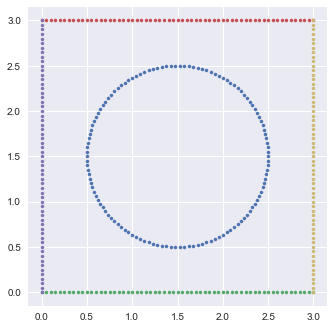

In [3]:
# points fixed on circle
Na = int(round(2*math.pi*r/h0))
ptsA = put_pts_on_circle(xc,yc,r,Na)

# points fixed on square
Nb = int(round((xmax - xmin)/h0))
ptsB = put_pts_on_square(xmin,xmax,Nb)

# total points fixed
Nfix = Na + 4*Nb + 1

# scatter plot of fixed points
plt.scatter(ptsA[:,0],ptsA[:,1],s=10)
plt.scatter(ptsB[0][:,0],ptsB[0][:,1],s=10)
plt.scatter(ptsB[1][:,0],ptsB[1][:,1],s=10)
plt.scatter(ptsB[2][:,0],ptsB[2][:,1],s=10)
plt.scatter(ptsB[3][:,0],ptsB[3][:,1],s=10)
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})

count =  200 displacement =  0.01493435211585355
count =  400 displacement =  0.0027809226809467134
count =  600 displacement =  0.005547309944739343
count =  800 displacement =  0.0032181460785566957
count =  1000 displacement =  0.0061030513954991004


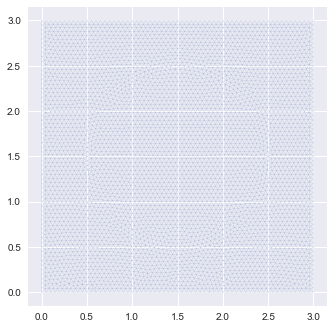

In [4]:
# mesh generation

bbox = [xmin,xmax,ymin,ymax]
pfix = np.zeros((Nfix,2))
    
pfix[0:Na,:] = ptsA
    
pfix[Na:Na+Nb+1,:] = ptsB[0]
pfix[Na+Nb:Na+2*Nb+1,:] = ptsB[1]
pfix[Na+2*Nb:Na+3*Nb+1,:] = ptsB[2]
pfix[Na+3*Nb:Na+4*Nb+1,:] = ptsB[3]

def dfunc(p):
        
    return drectangle(p,xmin,xmax,ymin,ymax)

pts, tri = distmesh2D(dfunc,huniform,h0,bbox,pfix)

Npts = np.size(pts,axis=0)
Ntri = np.size(tri,axis=0)  

<ipython-input-12-dc5f36e70488>:23: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label="Potential", orientation="vertical")


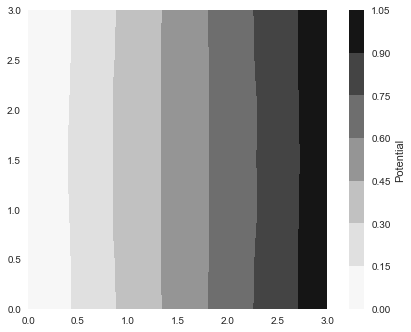

In [12]:
# Case A

#conductivities
a1 = 1.2
a2 = 1.0

def fpot(pts):
    return face(pts,par,a1,a2)

# find the mesh points lying on the Dirichlet boundary
NAind, Aind = find_bdry_pts_rec_ver(pts,xmin,h0)   #Dirchlet boundary x=0
NBind, Bind = find_bdry_pts_rec_ver(pts,xmax,h0)   #Dirchlet boundary x=3

def fpot(pts):
    return face(pts,par,a1,a2)

# find using FEM
q = FEM_solver(pts,tri,Aind,Aval,Bind,Bval,fpot)

# visualize solution
fig = plt.figure()
plt.tricontourf(pts[:,0], pts[:,1], q)
plt.colorbar(label="Potential", orientation="vertical")
axes = plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})

<Figure size 576x396 with 0 Axes>

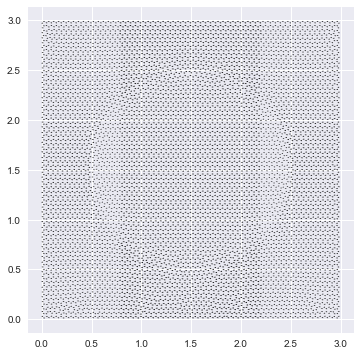

In [13]:
q_grad = np.zeros((len(tri),2))
pts_mid = np.zeros((len(tri),2))

for j in range(Ntri):
    
    v = pts[tri[j,:],:] 
    i1 = np.where((pts == v[0]).all(axis=1))
    i2 = np.where((pts == v[1]).all(axis=1))
    i3 = np.where((pts == v[2]).all(axis=1))
    
    x = np.zeros((3,3))
    x[:,0] = 1
    x[:,1] = v[:,0]
    x[:,2] = v[:,1]
    
    b = ( q[i1]*(v[1][1] - v[2][1]) + q[i2]*(v[2][1] - v[0][1]) + q[i3]*(v[0][1] - v[1][1]) )/np.linalg.det(x)
    c = ( q[i1]*(v[1][0] - v[2][0]) + q[i2]*(v[2][0] - v[0][0]) + q[i3]*(v[0][0] - v[1][0]) )/np.linalg.det(x)
    
    vmid = np.reshape(np.sum(v,axis=0)/3,(1,2)) # midpoint of mesh triangle
    pts_mid[j] = vmid[0]

    
    y = np.array([b,c]).reshape(1,2)
    
    if np.sqrt((vmid[0][0]-xc)**2+(vmid[0][0]-yc)**2)-r < h0*1e-2:
    
        q_grad[j] = -a1*y
        
    else:
    
        q_grad[j] = -a2*y
        
# visualize gradient
fig = plt.figure()
plt.figure(figsize=(6,6))
plt.quiver(pts_mid[:,0], pts_mid[:,1], q_grad[:,0], q_grad[:,1])
axes = plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})

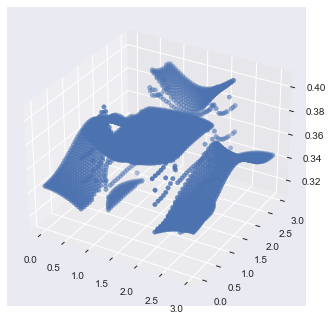

<Figure size 576x576 with 0 Axes>

In [14]:
abs_current_verts = np.zeros((Npts, 1))
count_tri = np.zeros((Npts, 1))

for j in range(Ntri):
    abs_current_verts[tri[j,:]] += np.sqrt(np.dot(q_grad[j],q_grad[j]))
    count_tri[tri[j,:]] += 1

abs_current_verts = abs_current_verts / count_tri


fig = plt.figure()
plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

ax.scatter(pts[:,0], pts[:,1], abs_current_verts)
plt.show()

<ipython-input-15-b8aae5081c88>:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label="Potential", orientation="vertical")


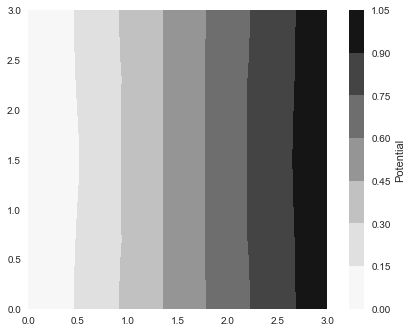

In [15]:
#conductivities
a1 = 0.8
a2 = 1.0

# find using FEM
q = FEM_solver(pts,tri,Aind,Aval,Bind,Bval,fpot)

# visualize solution
fig = plt.figure()
plt.tricontourf(pts[:,0], pts[:,1], q)
plt.colorbar(label="Potential", orientation="vertical")
axes = plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})

<Figure size 576x396 with 0 Axes>

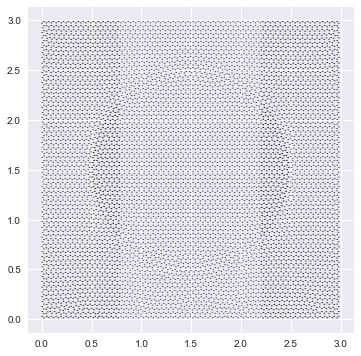

In [16]:
q_grad = np.zeros((len(tri),2))
pts_mid = np.zeros((len(tri),2))

for j in range(Ntri):
    
    v = pts[tri[j,:],:] 
    i1 = np.where((pts == v[0]).all(axis=1))
    i2 = np.where((pts == v[1]).all(axis=1))
    i3 = np.where((pts == v[2]).all(axis=1))
    
    x = np.zeros((3,3))
    x[:,0] = 1
    x[:,1] = v[:,0]
    x[:,2] = v[:,1]
    
    b = ( q[i1]*(v[1][1] - v[2][1]) + q[i2]*(v[2][1] - v[0][1]) + q[i3]*(v[0][1] - v[1][1]) )/np.linalg.det(x)
    c = ( q[i1]*(v[1][0] - v[2][0]) + q[i2]*(v[2][0] - v[0][0]) + q[i3]*(v[0][0] - v[1][0]) )/np.linalg.det(x)
    
    vmid = np.reshape(np.sum(v,axis=0)/3,(1,2)) # midpoint of mesh triangle
    pts_mid[j] = vmid[0]

    
    y = np.array([b,c]).reshape(1,2)
    
    if np.sqrt((vmid[0][0]-xc)**2+(vmid[0][0]-yc)**2)-r < h0*1e-2:
    
        q_grad[j] = -a1*y
        
    else:
    
        q_grad[j] = -a2*y

# visualize gradient
fig = plt.figure()
plt.figure(figsize=(6,6))
plt.quiver(pts_mid[:,0], pts_mid[:,1], q_grad[:,0], q_grad[:,1])
axes = plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})

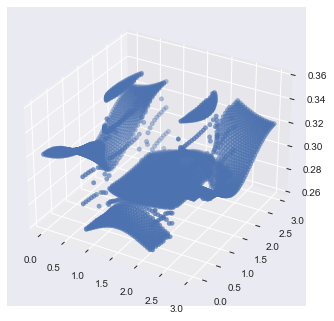

In [17]:
abs_current_verts = np.zeros((Npts, 1))
count_tri = np.zeros((Npts, 1))

for j in range(Ntri):
    abs_current_verts[tri[j,:]] += np.sqrt(np.dot(q_grad[j],q_grad[j]))
    count_tri[tri[j,:]] += 1

abs_current_verts = abs_current_verts / count_tri


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(pts[:,0], pts[:,1], abs_current_verts)

In both cases the current flows in the same direction. In one first case, the rate of flow of current is higher in the circle. In one second case, the rate of flow of current is lower in the circle. This is due to the difference in conductivities.